In [3]:
from clease.settings import Concentration
import numpy as np
np.random.seed(0)  # Set a seed for consistent tests

ModuleNotFoundError: No module named 'clease'

# ratio

In [7]:
# simple demo
conc = Concentration(basis_elements=[['Au', 'Cu']],)
conc.set_conc_formula_unit(formulas=["Au<x>Cu<1-x>"], variable_range={"x": (0, 1)})

In [ ]:
# one_sublattice

In [17]:
# Force the Au concentration to be equal to the Cu concentration
basis_elements = [['Au', 'Cu']]
A_eq = [[1.0, -1.0]]
b_eq = [0.0]
conc = Concentration(basis_elements=basis_elements, A_eq=A_eq, b_eq=b_eq)
for i in range(1):
    x = conc.get_random_concentration([20])
    print(x[0],x[1])

0.5000000000000002 0.5


In [22]:
# Force number of Au atoms to be larger than 12
A_lb = [[20, 0.0]]
b_lb = [12]
conc = Concentration(basis_elements=basis_elements, A_lb=A_lb, b_lb=b_lb)
for i in range(3):
    x = conc.get_random_concentration([20])
    print(x[0],x[1])

0.95 0.05
0.85 0.15
0.95 0.050000000000000044


In [25]:
# Force the concentration of O to be twice the concentration of F
basis_elements = [['Li', 'V'], ['O', 'F']]
A_eq = [[0.0, 0.0, -1.0, 2.0]]
b_eq = [0.0]
conc = Concentration(basis_elements=basis_elements, A_eq=A_eq, b_eq=b_eq)
for i in range(3):
    x = conc.get_random_concentration([18, 18])
    print(x[2] - 2*x[3])

0.0
0.0
0.0


In [27]:
# Li concentration larger than 0.2 and O concentration smaller than 0.7
A_lb = [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, -1.0, 0.0]]
b_lb = [0.2, -0.7]
conc = Concentration(basis_elements=basis_elements, A_lb=A_lb, b_lb=b_lb)
for i in range(3):
   x = conc.get_random_concentration([18, 18])
   print(x[0],x[2])

0.8333333333333334 0.6111111111111112
0.2777777777777778 0.2777777777777778
0.5 0.05555555555555555


In [ ]:
from clease.settings import CEBulk
settings = CEBulk(crystalstructure='fcc',
                  a=3.8,
                  supercell_factor=64,
                  concentration=conc,
                  db_name="aucu.db",
                  max_cluster_dia=[6.0, 4.5, 4.5])

# Specify CE settings

In [2]:
# 元素和比例的设置
from clease.settings import Concentration
conc = Concentration(basis_elements=[['Au', 'Cu']],)
conc.set_conc_formula_unit(formulas=["Au<x>Cu<1-x>"], variable_range={"x": (0, 1)})

# 模板
from ase.build import bulk, make_supercell
import numpy as np
tem = bulk("Au","fcc",a=3.8)
tem = make_supercell(tem, 5*np.eye(3))

#  初始化设置
from clease.settings import CEBulk
settings = CEBulk(crystalstructure='fcc',
                  a=3.8,
                  #size=(2,2,2),
                  supercell_factor=128, # 最大扩胞的数量
                  concentration=conc,
                  db_name="aucu.db",
                  max_cluster_dia=[6.0, 4.5, 4.5]
                 )

# settings.view_clusters() # 查看团簇
# settings.view_templates() # 查看模板

In [3]:
# 得到初始的100%比例构型
from clease.structgen import NewStructures
ns = NewStructures(settings, generation_number=0, struct_per_gen=2)
ns.generate_initial_pool()

In [4]:
# 随机生成构型
ns = NewStructures(settings, generation_number=0, struct_per_gen=10)
ns.generate_random_structures()

In [8]:
# 计算未收敛的构型
from ase.calculators.emt import EMT
from ase.db import connect
from clease.tools import update_db

def calcAtoms():
    calc = EMT()
    db_name = "aucu.db"
    db = connect(db_name)

    # Run calculations for all structures that are not converged.
    for row in db.select(converged=False):
      atoms = row.toatoms()
      atoms.calc = calc
      atoms.get_potential_energy()
      update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)
calcAtoms()

C:\Users\gchen\AppData\Local\Temp\ipykernel_16112\2053599826.py:12: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)


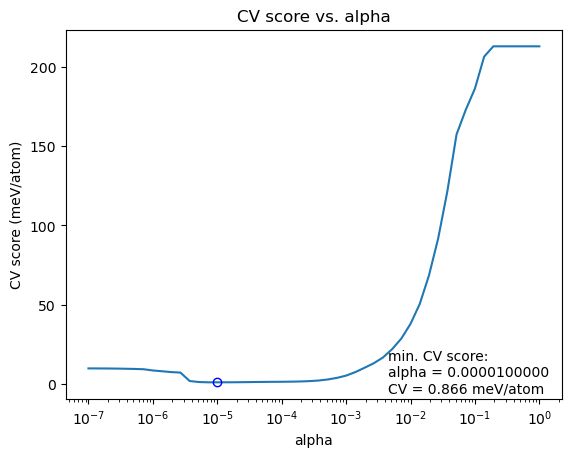

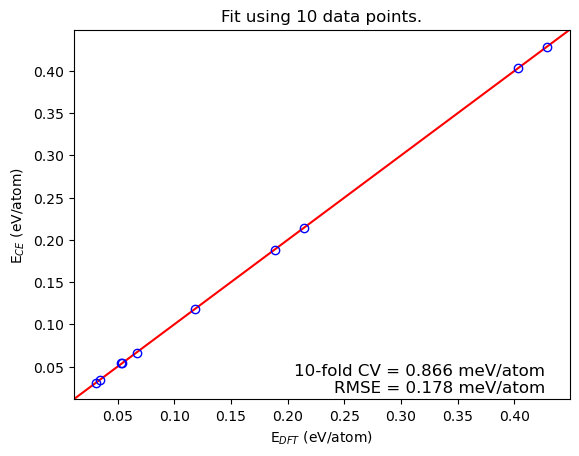

In [9]:
# 评估的函数
from clease import Evaluate
import clease.plot_post_process as pp
import matplotlib.pyplot as plt
def evaluate(settings_=settings, plot_cv=True, plot_fit=True, plot_eci=False, plot_convex_hull=False):
    eva = Evaluate(settings=settings_, scoring_scheme='k-fold', nsplits=10)
    # scan different values of alpha and return the value of alpha that yields
    # the lowest CV score
    eva.set_fitting_scheme(fitting_scheme='l1')
    
    if plot_cv:
        alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)

    # set the alpha value with the one found above, and fit data using it.
    eva.set_fitting_scheme(fitting_scheme='l1', alpha=alpha)
    eva.fit()  # Run the fit with these settings.
    
    if plot_fit:
        fig = pp.plot_fit(eva)
        plt.show()

    # plot ECI values
    if plot_eci:
        fig = pp.plot_eci(eva)
        plt.show()
        # save a dictionary containing cluster names and their ECIs
    eva.save_eci(fname='eci_l1')
    
    if plot_convex_hull:
        fig = pp.plot_convex_hull(eva)
        plt.show()

evaluate(settings)

In [10]:
# 随机生成构型-1
ns = NewStructures(settings, generation_number=1, struct_per_gen=20)
ns.generate_random_structures()

C:\Users\gchen\AppData\Local\Temp\ipykernel_16112\2053599826.py:12: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)


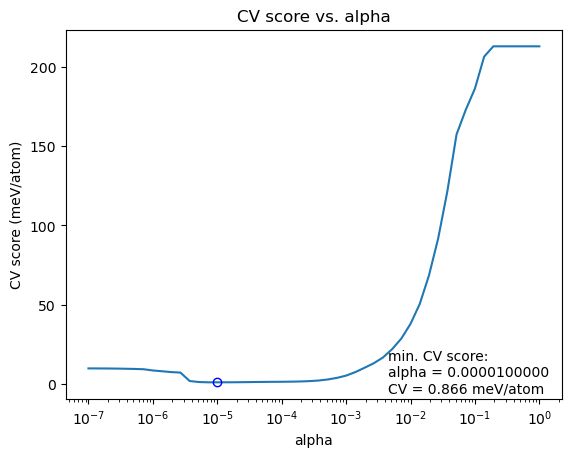

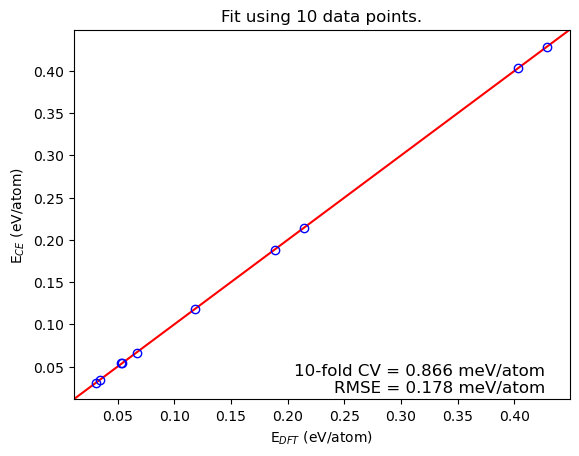

In [11]:
# 评估 - 此时评估无变化
evaluate(settings)

In [12]:
# 用已经拟合的去探索结构
ns = NewStructures(settings, generation_number=2, struct_per_gen=20)
ns.generate_probe_structure()

C:\Users\gchen\AppData\Local\Temp\ipykernel_16112\2053599826.py:12: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)


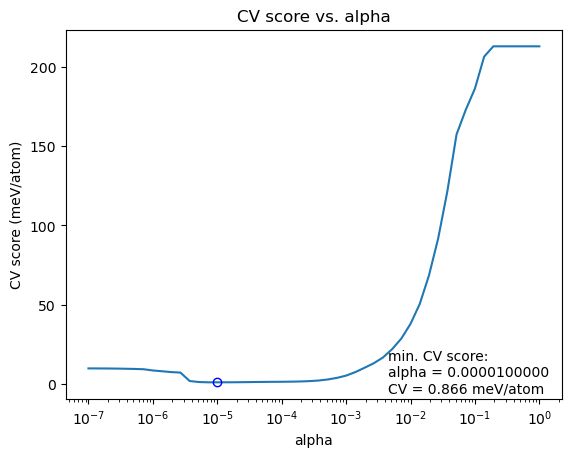

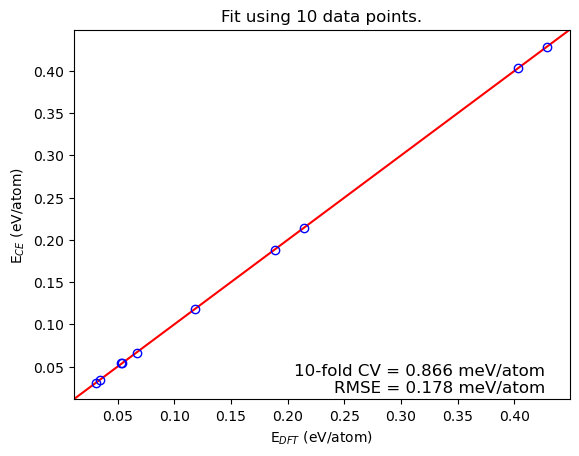

In [14]:
# 评估 - 此时得分不变
evaluate(settings)

In [15]:
# 计算
calcAtoms()

C:\Users\gchen\AppData\Local\Temp\ipykernel_16112\2053599826.py:12: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)


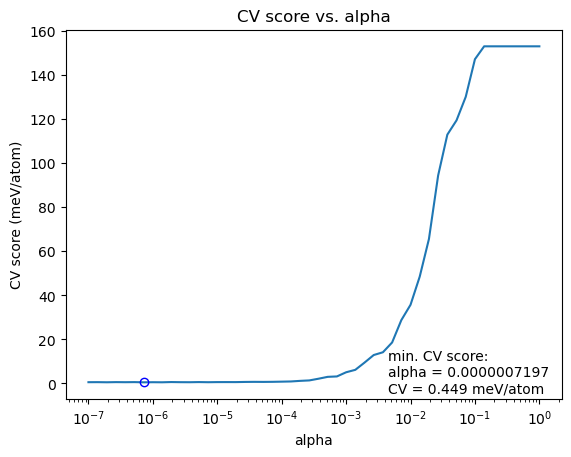

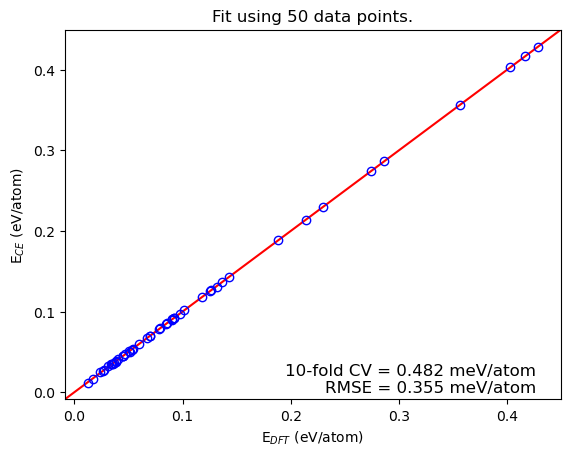

In [16]:
# 评估
evaluate(settings)

C:\Users\gchen\AppData\Local\Temp\ipykernel_16112\2053599826.py:12: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)


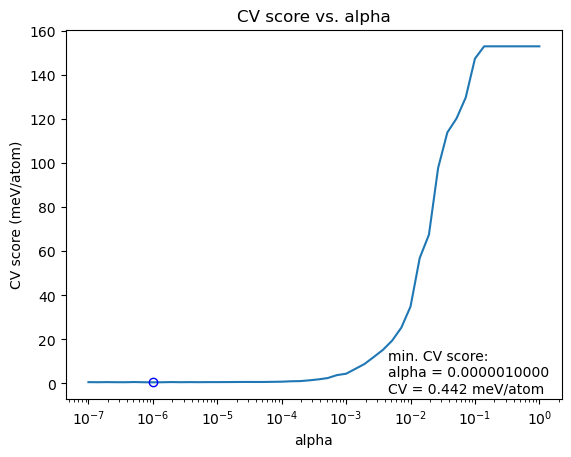

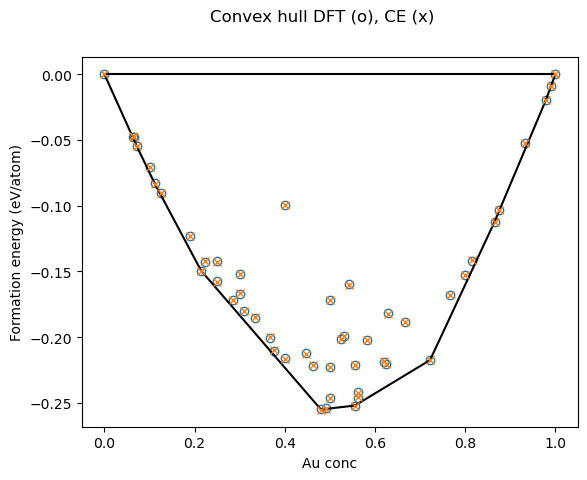

In [18]:
# plot_convex_hull
evaluate(settings, plot_cv=True, plot_fit=False, plot_convex_hull=True)

In [20]:
# 产生基态结构
from ase.db import connect
import json

# get template
template = tem

# import dictionary containing cluster names and their ECIs
with open('eci_l1.json') as f:
    eci = json.load(f)

ns = NewStructures(settings, generation_number=3, struct_per_gen=10)

ns.generate_gs_structure(atoms=template, init_temp=2000,
                         final_temp=1, num_temp=10,
                         num_steps_per_temp=5000,
                         eci=eci, random_composition=True)

In [22]:
# 计算
calcAtoms()

C:\Users\gchen\AppData\Local\Temp\ipykernel_16112\2053599826.py:12: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)


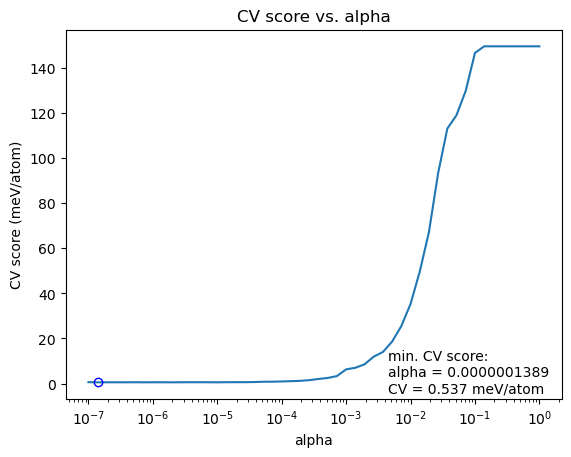

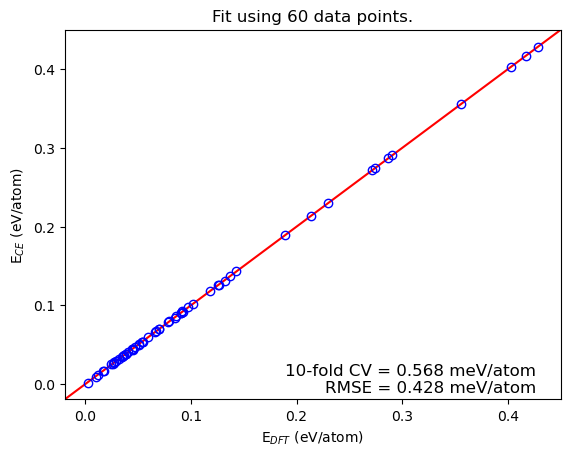

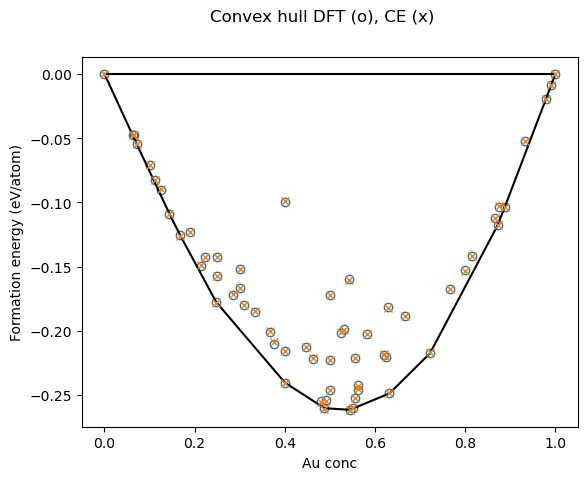

In [23]:
# 评估
evaluate(settings, plot_convex_hull=True)

In [ ]:
"""
from ase.io import read
conc = Concentration(basis_elements=[['N', 'H']],)
conc.set_conc_formula_unit(formulas=["N<x>H<1-x>"], variable_range={"x": (0, 1)})
atoms = read("./POSCAR")
from clease.settings import ClusterExpansionSettings
setting = ClusterExpansionSettings(
    prim=atoms,
    concentration=conc,
    db_name="nh.db",
    size=(1,1,1),
    #supercell_factor=2,
    #max_cluster_dia=[5, 5, 5, 5],
    #basis_func_type="binary_linear",
    #include_background_atoms=True,
)

from ase.db import connect
atoms_tem = connect('nh.db').get(id=1).toatoms()
from clease.structgen import NewStructures
ns = NewStructures(setting, generation_number=0, struct_per_gen=1)
ns.generate_initial_pool(atoms_tem)
"""